<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Авторы материала: Data Science интерн Ciklum, студент магистерской программы CSDS UCU Виталий Радченко, аналитик Вымпелком Саян Омаров

# <center> Домашнее задание № 5
## <center> Логистическая регрессия и случайный лес в задаче кредитного скоринга

#### Нашей главной задачей будет построение модели для задачи кредитного скоринга.

Но для разминки решите первое задание :)

**Задание 1** В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?
- 70.00%
- 83.20%
- 83.70%
- 87.50%

Теперь перейдем непосредственно к машинному обучению.

#### Данные представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	     ----Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                         ---- Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	----Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio ----	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	----Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate ----Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse----	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; ; тип -	integer
* NumberOfDependents ----Число человек в семье кредитозаёмщика; тип -	integer

In [13]:
def fact(n):
    x = 1
    for i in range(n):
        x = x*(i+1)
    return x

In [155]:
def voice(n,p):
    x = 0
    for i in range(1,n):
        print(i)
        x = x+ (fact(n)/(fact(n-i)*fact(i)))*pow(p,i)*pow(1-p,n-i)
    return x

In [156]:
voice(5,0.7)

1
2
3
4


0.8295000000000001

In [152]:
voice(5,0.7)

2
3
4


0.80115

In [29]:
voice(5,0.7)

0
1
2
3
4


0.8319300000000001

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [31]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы 
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

In [32]:
## Считываем данные
data = pd.read_csv('data/credit_scoring_sample.csv', sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158,0
1,0,58,0,3870.000000,0,0,NaN,0
2,0,41,0,0.456127,0,0,6666,0
3,0,43,0,0.000190,0,0,10500,2
4,1,49,0,0.271820,0,0,400,0


In [33]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

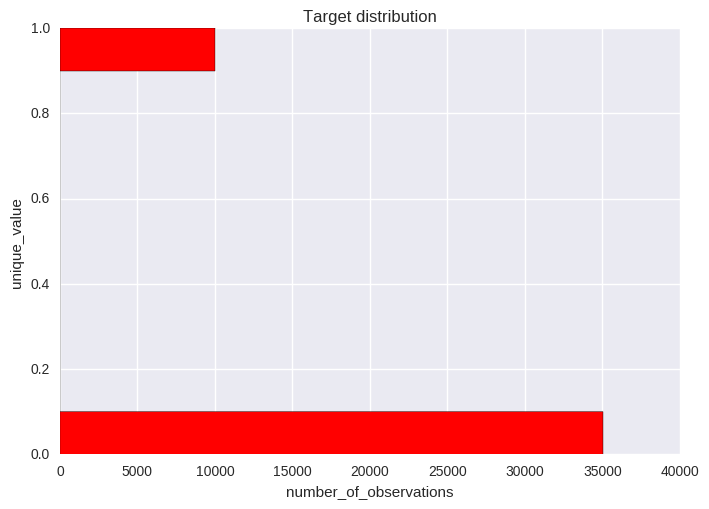

In [34]:
## Посмотрим на распределение классов в зависимой переменной

ax =data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [37]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names


['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [36]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table =delete_nan(data)


In [38]:
## Разделяем таргет и признаки 
X =table[independent_columns_names]
y = table['SeriousDlqin2yrs']


# Бутстрэп

**Задание 2.** Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". (используйте пример из статьи. Поставьте np.random.seed(0) как это сделано в статье)

In [39]:
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158,0
1,0,58,0,3870.000000,0,0,5166,0
2,0,41,0,0.456127,0,0,6666,0
3,0,43,0,0.000190,0,0,10500,2
4,1,49,0,0.271820,0,0,400,0


In [160]:
import numpy as np
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
loyal_calls = data[data['SeriousDlqin2yrs'] == 1]['age'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
loyal_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(loyal_calls, 1000)]

#  выводим интервальную оценку среднего
print("Service calls from loyal:  mean interval",  stat_intervals(loyal_mean_scores, 0.1))

Service calls from loyal:  mean interval [ 45.71379414  46.12700479]


In [158]:
100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)

(2.5, 97.5)

## Подбор параметров для модели логистической регрессии 

#### Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0  до 1.   Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [161]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны, 
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть 
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

**Задание 3.**
Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [162]:

from sklearn.metrics import roc_auc_score

In [163]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
C = [0.0001, 0.001, 0.01, 0.1, 1, 10]

# Обучаем на тренировочном датасетеc
for c in C:
    lr = LogisticRegression(C = c,random_state=5, class_weight= 'balanced')#rfc
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lr.fit(X_train, y_train)
        temp_train_acc.append(roc_auc_score(y_train, lr.predict(X_train)))
        temp_test_acc.append(roc_auc_score(y_test, lr.predict(X_test)))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.10f}AUC with {} C".format(max(test_acc.mean(axis=1)), 
                                                        C[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 0.7204214051AUC with 0.001 C


In [164]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}
lr = LogisticRegression(random_state=5, class_weight= 'balanced')
clf = GridSearchCV(lr, parameters, cv=skf,scoring='roc_auc')
clf.fit(X, y)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=5,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [165]:
print("Best params:", clf.best_params_)
print("Best cross validaton score", clf.best_score_)

Best params: {'C': 0.001}
Best cross validaton score 0.79620647691


In [166]:
clf.cv_results_

{'mean_fit_time': array([ 0.33502822,  0.48777018,  0.50119519,  0.46815543,  0.3986836 ,
         0.40216017]),
 'mean_score_time': array([ 0.00562758,  0.00737014,  0.00640144,  0.00485191,  0.00453172,
         0.00565796]),
 'mean_test_score': array([ 0.79090936,  0.79620648,  0.79108324,  0.78883253,  0.78873232,
         0.78828926]),
 'mean_train_score': array([ 0.79110795,  0.79635282,  0.79129514,  0.78902306,  0.7888694 ,
         0.78850229]),
 'param_C': masked_array(data = [0.0001 0.001 0.01 0.1 1 10],
              mask = [False False False False False False],
        fill_value = ?),
 'params': ({'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10}),
 'rank_test_score': array([3, 1, 2, 4, 5, 6], dtype=int32),
 'split0_test_score': array([ 0.79006524,  0.79356999,  0.78806353,  0.78616989,  0.78582034,
         0.78510125]),
 'split0_train_score': array([ 0.79255473,  0.79725005,  0.79163639,  0.78959762,  0.78920305,
         0.7885093 ]),
 

In [118]:
test_acc.std(axis=1).mean(),test_acc.std(axis=1).max()

(0.0044466313197868007, 0.0066569229992795619)

In [119]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}
lr = LogisticRegression(random_state=5, class_weight= 'balanced')
clf = GridSearchCV(lr, parameters, cv=skf,scoring='roc_auc')
clf.fit(Xtr, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=5,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [167]:
print("Best params:", clf.best_params_)
print("Best cross validaton score", clf.best_score_)
test_acc.std(axis=1).mean(),test_acc.std(axis=1).max()

Best params: {'C': 0.001}
Best cross validaton score 0.79620647691


(0.0044466313197868007, 0.0066569229992795619)

In [168]:
0.5/100

0.005

**Задание 4.** 
Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [53]:
[ 0.0036604 ,  0.00352789,  0.00382522,  0.00391643,  0.00378448,0.00410085]


array([ 0.00488296,  0.00665692,  0.00372471,  0.00381402,  0.00361929,
        0.00398188])

In [58]:
test_acc.std(axis=1).mean(),test_acc.std(axis=1).max()

(0.0044466313197868007, 0.0066569229992795619)

In [56]:
test_acc.std(axis=1).mean()<0.5/100

True

## Определение влияния признаков

**Задание 5.**
Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [170]:
from sklearn import preprocessing

In [194]:
Xtr = preprocessing.MinMaxScaler().fit_transform(X)
Xtr = pd.DataFrame(Xtr)
Xtr.columns = X.columns

In [178]:
Xtr = preprocessing.scale(X)
Xtr = pd.DataFrame(Xtr)
Xtr.columns = X.columns

In [206]:
scaler = preprocessing.StandardScaler().fit(X)
Xtr = scaler.transform(X)  
Xtr = pd.DataFrame(Xtr)
Xtr.columns = X.columns

In [195]:
Xtr.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0.500000,0,7.655510e-07,0,0,0.004547,0.0
1,0.430233,0,1.185509e-02,0,0,0.002880,0.0
2,0.232558,0,1.397268e-06,0,0,0.003716,0.0
3,0.255814,0,5.820329e-10,0,0,0.005853,0.2
4,0.325581,0,8.326747e-07,0,0,0.000223,0.0


In [207]:
Xtr.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0.872891,-0.121432,-0.142577,-0.092452,-0.082208,0.171676,-0.685453
1,0.463373,-0.121432,1.425692,-0.092452,-0.082208,-0.091407,-0.685453
2,-0.696928,-0.121432,-0.142493,-0.092452,-0.082208,0.040486,-0.685453
3,-0.560422,-0.121432,-0.142678,-0.092452,-0.082208,0.377605,1.094817
4,-0.150904,-0.121432,-0.142568,-0.092452,-0.082208,-0.510476,-0.685453


In [208]:
%%time
lr = LogisticRegression(random_state=5, class_weight= 'balanced')
lr.fit(Xtr, y)

CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 190 ms


In [209]:
lr.coef_

array([[-0.43649935,  3.26126184, -0.0423393 ,  3.03834556,  0.09020356,
        -0.20410506,  0.08534058]])

In [193]:
Xtr.columns

Index(['age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse',
       'MonthlyIncome', 'NumberOfDependents'],
      dtype='object')

In [80]:
logit.coef_

array([[-0.43740536,  2.7989246 , -0.04112929,  2.17911647, -4.59321872,
        -0.31248476,  0.11278966]])

In [198]:
%%time
lr = LogisticRegression(random_state=5, class_weight= 'balanced')
lr.fit(Xtr, y)


CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 135 ms


In [199]:
lr.coef_

array([[ -2.68485736,  25.68961925,  -0.71178398,  19.36079325,
          6.0579401 ,  -2.79744923,   0.76287729]])

In [211]:
s = [-2.68485736,  25.68961925,  -0.71178398,  19.36079325,6.0579401 ,  -2.79744923,   0.76287729]

**Задание 6.** Посчитайте долю влияния `DebtRatio` на предсказание. (Воспользуйтесь функцией [softmax](https://en.wikipedia.org/wiki/Softmax_function))

In [210]:
np.exp(-0.04112929)/np.sum(np.exp(lr.coef_))

0.018614513850557814

In [212]:
np.exp(-0.71178398)/np.sum(np.exp(s))

3.4138317660569393e-12

**Задание 7.** 
Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заного оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть [здесь](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf))

In [213]:
%%time
lr = LogisticRegression(random_state=5, class_weight= 'balanced')
lr.fit(X, y)

CPU times: user 464 ms, sys: 0 ns, total: 464 ms
Wall time: 466 ms


In [216]:
lr.coef_


array([[ -2.96564805e-02,   5.30832112e-01,  -1.70929384e-05,
          4.97813660e-01,   1.25596595e-02,  -1.78447609e-05,
          7.62877665e-02]])

In [217]:
Xtr_d = X.copy()
Xtr_d['age'] = Xtr_d['age']+20
Xtr_d.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,84,0,0.249908,0,0,8158,0
1,78,0,3870.000000,0,0,5166,0
2,61,0,0.456127,0,0,6666,0
3,63,0,0.000190,0,0,10500,2
4,69,0,0.271820,0,0,400,0


In [219]:
lr.predict_proba(X)[:,1]-lr.predict_proba(Xtr_d)[:,1]

array([ 0.10154837,  0.11072342,  0.13645334, ...,  0.14491926,
        0.14695187,  0.13883289])

In [220]:
Xtr_d.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,84,0,0.249908,0,0,8158,0
1,78,0,3870.000000,0,0,5166,0
2,61,0,0.456127,0,0,6666,0
3,63,0,0.000190,0,0,10500,2
4,69,0,0.271820,0,0,400,0


In [95]:
logit.fit(abs(Xtr),y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [96]:
logit.predict_proba(Xtr)[:,1]-logit.predict_proba(Xtr_d)[:,1]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
        -1.11022302e-16,   0.00000000e+00,   0.00000000e+00])

In [97]:
logit.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [98]:
Xtr_d = X.copy()
Xtr_d['age'] = Xtr_d['age']+20

In [221]:
(lr.predict_proba(Xtr_d)[:,1]/lr.predict_proba(X)[:,1])

array([ 0.62993183,  0.64107534,  0.68592562, ...,  0.71630174,
        0.7526011 ,  0.79804168])

In [222]:
(lr.predict_proba(Xtr_d)[:,1]/lr.predict_proba(X)[:,1]).mean()

0.69736590681561506

In [223]:
(lr.predict_proba(X)[:,1]/lr.predict_proba(Xtr_d)[:,1]).mean()

1.4495506632407706

In [109]:
logit.coef_

array([[ -2.90269037e-02,   4.41469478e-01,  -1.67382924e-05,
          3.09019602e-01,  -6.28792346e-01,  -2.74530793e-05,
          1.04982942e-01]])

In [101]:
X.columns

Index(['age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse',
       'MonthlyIncome', 'NumberOfDependents'],
      dtype='object')

In [103]:
np.exp(20*-2.90269037e-02)

0.55959718084907895

In [104]:
np.exp(20*2.90269037e-02)

1.7869997101892046

# Случайный лес

In [110]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами 
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, oob_score=True, class_weight='balanced')

## Будем искать лучшие параметры среди следующего набора
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}

## Делаем опять же стрэтифайд k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf

In [240]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1,scoring='roc_auc')
gcv.fit(X, y)

print("Best params:", gcv.best_params_)
print("Best cross validaton score", gcv.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.5min finished


Best params: {'max_depth': 10, 'min_samples_leaf': 7, 'max_features': 2}
Best cross validaton score 0.836334348707


In [241]:
0.836334348707-0.795483081061

0.040851267646

In [122]:
rf =RandomForestClassifier(max_depth = 15, min_samples_leaf = 9, max_features = 2,n_estimators=100, n_jobs=-1, random_state=42, oob_score=True, class_weight='balanced')

**Задание 8.** На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [17]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
C = [1, 2, 4]

# Обучаем на тренировочном датасетеc
for c in C:
    lr = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, oob_score=True, class_weight='balanced')
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lr.fit(X_train, y_train)
        temp_train_acc.append(roc_auc_score(y_train, lr.predict(X_train)))
        temp_test_acc.append(roc_auc_score(y_test, lr.predict(X_test)))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}AUC with {} max_features".format(max(test_acc.mean(axis=1)), 
                                                        C[np.argmax(test_acc.mean(axis=1))]))

In [ ]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
C = [3, 5, 7, 9]

# Обучаем на тренировочном датасетеc
for c in C:
    lr = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, oob_score=True, class_weight='balanced')
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lr.fit(X_train, y_train)
        temp_train_acc.append(roc_auc_score(y_train, lr.predict(X_train)))
        temp_test_acc.append(roc_auc_score(y_test, lr.predict(X_test)))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}AUC with {} min_samples_leaf".format(max(test_acc.mean(axis=1)), 
                                                        C[np.argmax(test_acc.mean(axis=1))]))

In [ ]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
C =  [5,10,15]

# Обучаем на тренировочном датасетеc
for c in C:
    lr = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, oob_score=True, class_weight='balanced')
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lr.fit(X_train, y_train)
        temp_train_acc.append(roc_auc_score(y_train, lr.predict(X_train)))
        temp_test_acc.append(roc_auc_score(y_test, lr.predict(X_test)))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}AUC with {} max_depth".format(max(test_acc.mean(axis=1)), 
                                                        C[np.argmax(test_acc.mean(axis=1))]))

In [225]:
X.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,64,0,0.249908,0,0,8158,0
1,58,0,3870.000000,0,0,5166,0
2,41,0,0.456127,0,0,6666,0
3,43,0,0.000190,0,0,10500,2
4,49,0,0.271820,0,0,400,0


**Задание 9.** Определите какой признак имеет самое слабое влияние.

In [224]:
rf =RandomForestClassifier(max_depth = 15, min_samples_leaf = 9, max_features = 2,n_estimators=100, n_jobs=-1, random_state=42, oob_score=True, class_weight='balanced')
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features=2,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=9, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [226]:
importances = rf.feature_importances_
importances

array([ 0.13776939,  0.23802945,  0.1408847 ,  0.23067374,  0.12562715,
        0.106195  ,  0.02082059])

In [227]:
np.argmin(importances)

6

In [231]:
X.columns

Index(['age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse',
       'MonthlyIncome', 'NumberOfDependents'],
      dtype='object')

In [228]:
X.columns[6]

'NumberOfDependents'

In [ ]:
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность конструктов")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])

Feature ranking:
1. feature 1 (0.238029)
2. feature 3 (0.230674)
3. feature 2 (0.140885)
4. feature 0 (0.137769)
5. feature 4 (0.125627)
6. feature 5 (0.106195)
7. feature 6 (0.020821)


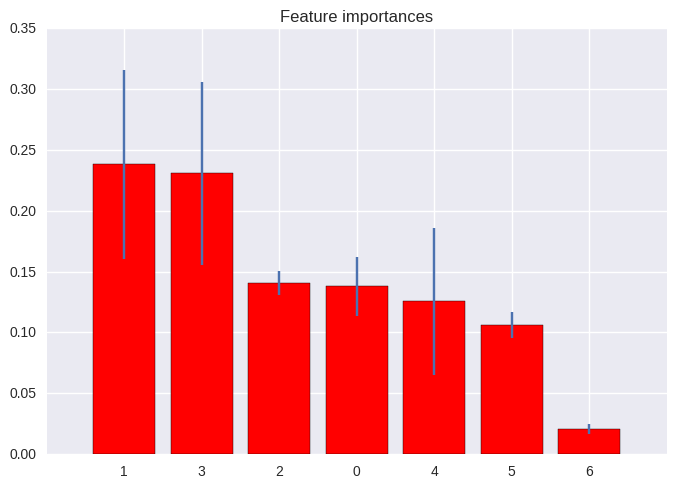

In [128]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [18]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import seaborn as sns
# russian headres
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)
import pandas as pd
import numpy as np
from sklearn.ensemble.forest import RandomForestRegressor

hostel_data = pd.read_csv("../../data/hostel_factors.csv")
features = {"f1":u"Персонал",
"f2":u"Бронирование хостела ",
"f3":u"Заезд в хостел и выезд из хостела",
"f4":u"Состояние комнаты",
"f5":u"Состояние общей кухни",
"f6":u"Состояние общего пространства",
"f7":u"Дополнительные услуги",
"f8":u"Общие условия и удобства",
"f9":u"Цена/качество",
"f10":u"ССЦ"}

forest = RandomForestRegressor(n_estimators=1000, max_features=10,
                                random_state=0)

forest.fit(hostel_data.drop(['hostel', 'rating'], axis=1), 
           hostel_data['rating'])
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность конструктов")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices]);

** Задание 10.** Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?

- меньше тратится времени для тренировки модели;
- меньше параметров для перебора;
- интепретируемость признаков;
- линейные свойства алгоритма.

# Бэггинг

In [243]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

**Задание 11.** Следующая задача обучить бэггинг классификатор (random_state=42). В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не GridSearchCV, а RandomizedSearchCV. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для RandomizedSearchCV. Так же не забудьте передать параметр валидации cv и `random_state=1`. Какая лучшая точность получилась?

In [244]:
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

In [245]:
bc = BaggingClassifier(base_estimator = lr,n_estimators = 100,n_jobs=-1,random_state=42)

In [246]:
random_search = RandomizedSearchCV(bc, param_distributions=parameters,cv = skf,n_iter=20,verbose=1,random_state=1,scoring='roc_auc')
random_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 14.4min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
          error_score='raise',
          estimator=BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=5,
          solver='liblinear', tol=0.0001, verbose=0, warm_st...n_estimators=100, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_samples': [0.5, 0.7, 0.9], 'max_features': [2, 3, 4], 'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=1)

In [247]:
random_search.best_score_

0.80746778722957357

In [248]:
np.argmax(random_search.cv_results_['mean_test_score'])

10

In [249]:
random_search.cv_results_['params'][10]

{'base_estimator__C': 0.001, 'max_features': 2, 'max_samples': 0.7}

In [144]:
random_search.cv_results_

{'mean_fit_time': array([  8.55203915,   4.4501503 ,  10.63382726,   8.04140692,
          8.05466566,   5.24736285,  10.96393642,   8.07565818,
          5.39366937,   5.28890152,   5.02955875,   6.21001306,
          7.90707607,   8.14613104,   8.10413208,  10.84319329,
         10.39856324,  11.05589895,   8.18635263,  10.89843016]),
 'mean_score_time': array([ 0.36360383,  0.36497369,  0.36817465,  0.37385502,  0.3660078 ,
         0.36086822,  0.36229815,  0.36296144,  0.35999556,  0.36905441,
         0.3617269 ,  0.36837659,  0.37217746,  0.36698799,  0.37348924,
         0.37841816,  0.36851168,  0.36813803,  0.36506238,  0.36986666]),
 'mean_test_score': array([ 0.78039633,  0.82713091,  0.77291791,  0.77981936,  0.77970841,
         0.80207709,  0.77380556,  0.77939773,  0.80212147,  0.81394936,
         0.82633202,  0.82761911,  0.80101192,  0.77964183,  0.7802188 ,
         0.7737168 ,  0.79493154,  0.77378337,  0.77979717,  0.77318421]),
 'mean_train_score': array([ 0.7805

In [ ]:
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [20]:
sklearn.model_selection.RandomizedSearchCV(estimator, parameters, n_iter=20, scoring=None, \
                                           fit_params=None, n_jobs=-1, iid=True, refit=True, cv=None, verbose=0,\
                                           pre_dispatch='2*n_jobs', random_state=42, error_score='raise',\
                                           return_train_score=True)

In [ ]:
start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

**Задача 12.** Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?

- для бэггинга важно использовать как можно меньше признаков
- бэггинг лучше работает на небольших выборках
- меньше корреляция между одиночными моделями
- чем больше признаков, тем меньше теряется информации